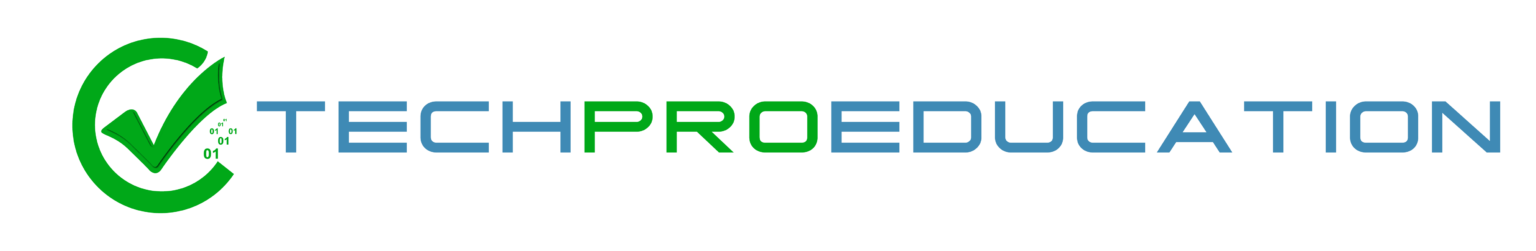

# Hand Written Digits Project

Data reference link : https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits

## Purpose

<style> div * {
    background-color:  #a0ced9;
    color: #fcf5c7;
    margin: 2px;
    border: dashed 1px blue;
}</style>
### data
Data obtained from 'handwritten digit' data collected with 250 samples from 44 subject authors.</div>

### aim
Guessing newly written handwritten digits.

### target column
Class

# Exploratory Data Analysis and Visualization

## Import Libs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError, ROCAUC

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 100

In [5]:
# Load Dataset
df = pd.read_csv("pendigits_txt.csv")
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


## Explore Data

In [6]:
# Summary Def

def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(df)


Data shape: (10992, 17)
___________________________
Data Types:
int64    17
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
class,int64,10992,10,0,0,9
input1,int64,10992,101,0,0,100
input10,int64,10992,101,0,0,100
input11,int64,10992,101,0,0,100
input12,int64,10992,101,0,0,100
input13,int64,10992,101,0,0,100
input14,int64,10992,101,0,0,100
input15,int64,10992,101,0,0,100
input16,int64,10992,101,0,0,100
input2,int64,10992,96,0,0,100


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
input1,10992.0,38.814320,34.257783,0.0,6.0,32.0,65.0,100.0
input2,10992.0,85.120269,16.218571,0.0,76.0,89.0,100.0,100.0
input3,10992.0,40.605622,26.342984,0.0,20.0,40.0,58.0,100.0
input4,10992.0,83.774199,19.163646,0.0,72.0,91.0,100.0,100.0
input5,10992.0,49.770378,34.100515,0.0,18.0,53.0,78.0,100.0
input6,10992.0,65.573144,26.996688,0.0,49.0,71.0,86.0,100.0
input7,10992.0,51.220251,30.576881,0.0,28.0,53.5,74.0,100.0
input8,10992.0,44.498999,29.906104,0.0,23.0,43.0,64.0,100.0
input9,10992.0,56.868541,34.135530,0.0,29.0,60.0,89.0,100.0
input10,10992.0,33.695961,27.251548,0.0,7.0,33.0,54.0,100.0


### Outlier Check
if iqr 1.5 accepted


In [8]:
def detect_outliers(df, col_name,tukey=1.5):
    ''' 
    this function detects outliers based on 1.5 time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(tukey*IQR)
    lower_limit = first_quartile-(tukey*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [9]:
threshold = 1.5
out_cols = []
for col in df.columns:
    print(
        f"{col}\nlower:{detect_outliers(df, col,threshold)[0]} \nupper:{detect_outliers(df, col,threshold)[1]}\
        \noutlier:{detect_outliers(df, col,threshold)[2]}\n*-*-*-*-*-*-*"
    )
    if detect_outliers(df, col,threshold)[2] > 0 :
        out_cols.append(col)
print(out_cols)   

input1
lower:-82.5 
upper:153.5        
outlier:0
*-*-*-*-*-*-*
input2
lower:40.0 
upper:136.0        
outlier:196
*-*-*-*-*-*-*
input3
lower:-37.0 
upper:115.0        
outlier:0
*-*-*-*-*-*-*
input4
lower:30.0 
upper:142.0        
outlier:153
*-*-*-*-*-*-*
input5
lower:-72.0 
upper:168.0        
outlier:0
*-*-*-*-*-*-*
input6
lower:-6.5 
upper:141.5        
outlier:0
*-*-*-*-*-*-*
input7
lower:-41.0 
upper:143.0        
outlier:0
*-*-*-*-*-*-*
input8
lower:-38.5 
upper:125.5        
outlier:0
*-*-*-*-*-*-*
input9
lower:-61.0 
upper:179.0        
outlier:0
*-*-*-*-*-*-*
input10
lower:-63.5 
upper:124.5        
outlier:0
*-*-*-*-*-*-*
input11
lower:-88.0 
upper:208.0        
outlier:0
*-*-*-*-*-*-*
input12
lower:-55.0 
upper:121.0        
outlier:0
*-*-*-*-*-*-*
input13
lower:3.0 
upper:107.0        
outlier:208
*-*-*-*-*-*-*
input14
lower:-58.0 
upper:110.0        
outlier:0
*-*-*-*-*-*-*
input15
lower:-150.0 
upper:250.0        
outlier:0
*-*-*-*-*-*-*
input16
lower:-76.5 
upper:127.5

In [10]:
out_cols
# outlier exist fields

['input2', 'input4', 'input13']

In [11]:
#make a copy for examine outliers difference 
df1 = df.copy()

In [12]:
for col in out_cols:
    df1 = df1[(df1[col] > detect_outliers(df1, col)[0])
             & (df1[col] < detect_outliers(df1, col)[1])]

In [13]:
df1.shape

(10450, 17)

In [15]:
#shows outlier difference --> not to much 
dif  = df.shape[0]-df1.shape[0]
dif

542

In [16]:
difPerc = dif /df.shape[0]
difPerc
# 5% is ok

0.04930858806404658

Text(0.5, 1.0, 'df1')

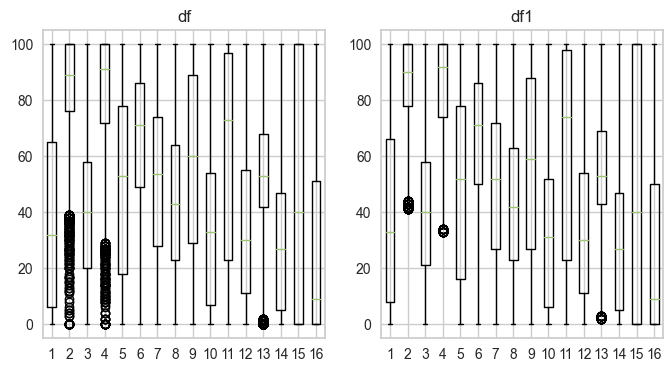

In [22]:
# show outlier difference with the subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Plot the data on each subplot
axs[0].boxplot(df.drop("class", axis=1))
axs[1].boxplot(df1.drop("class", axis=1))

# Set titles and axis labels
axs[0].set_title('df')
axs[1].set_title('df1')

In [41]:
# target column balance?
db = df['class'].value_counts().sort_index()
db

0    1143
1    1143
2    1144
3    1055
4    1144
5    1055
6    1056
7    1142
8    1055
9    1055
Name: class, dtype: int64

In [30]:
counts = df['class'].value_counts()

mean_counts = np.average(counts.values, weights=counts)

mean_counts

1100.9616084425036

In [40]:
# to understand diffence balance
total = 0
for i in range(0,10) :
    d =df['class'].value_counts()[i] - mean_counts
    print(d)
    total += d
total


42.038391557496425
42.038391557496425
43.038391557496425
-45.961608442503575
43.038391557496425
-45.961608442503575
-44.961608442503575
41.038391557496425
-45.961608442503575
-45.961608442503575


-17.61608442503575

<Axes: >

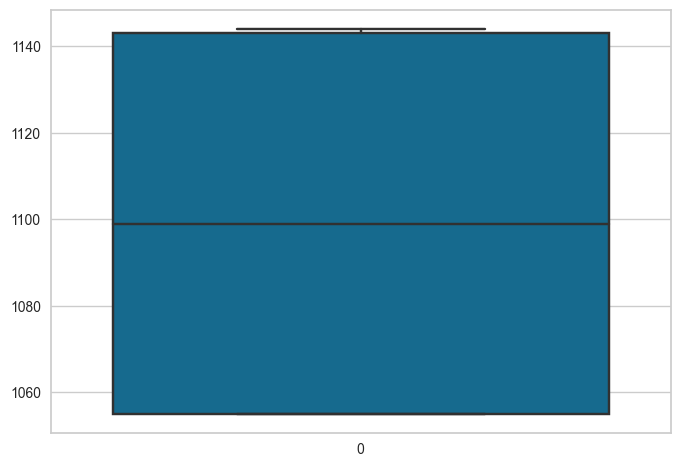

In [45]:
sns.boxplot(db)
#very balanced

AttributeError: 'Int64Index' object has no attribute 'patches'

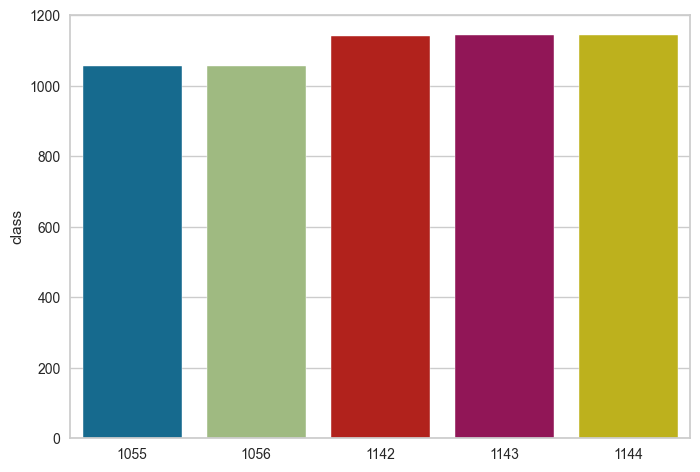

In [56]:
ax =sns.barplot(y = db.index, x = db.values, data = db)
plt.bar_label(db.index);

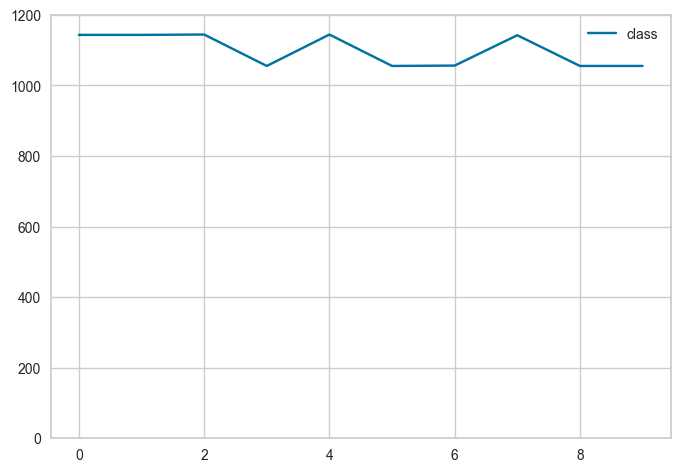

In [67]:
ddd = pd.DataFrame(db)
ax = sns.lineplot( data=ddd)
ax.set_ylim([0, 1200])

plt.show()
# seems balanced

## coralation

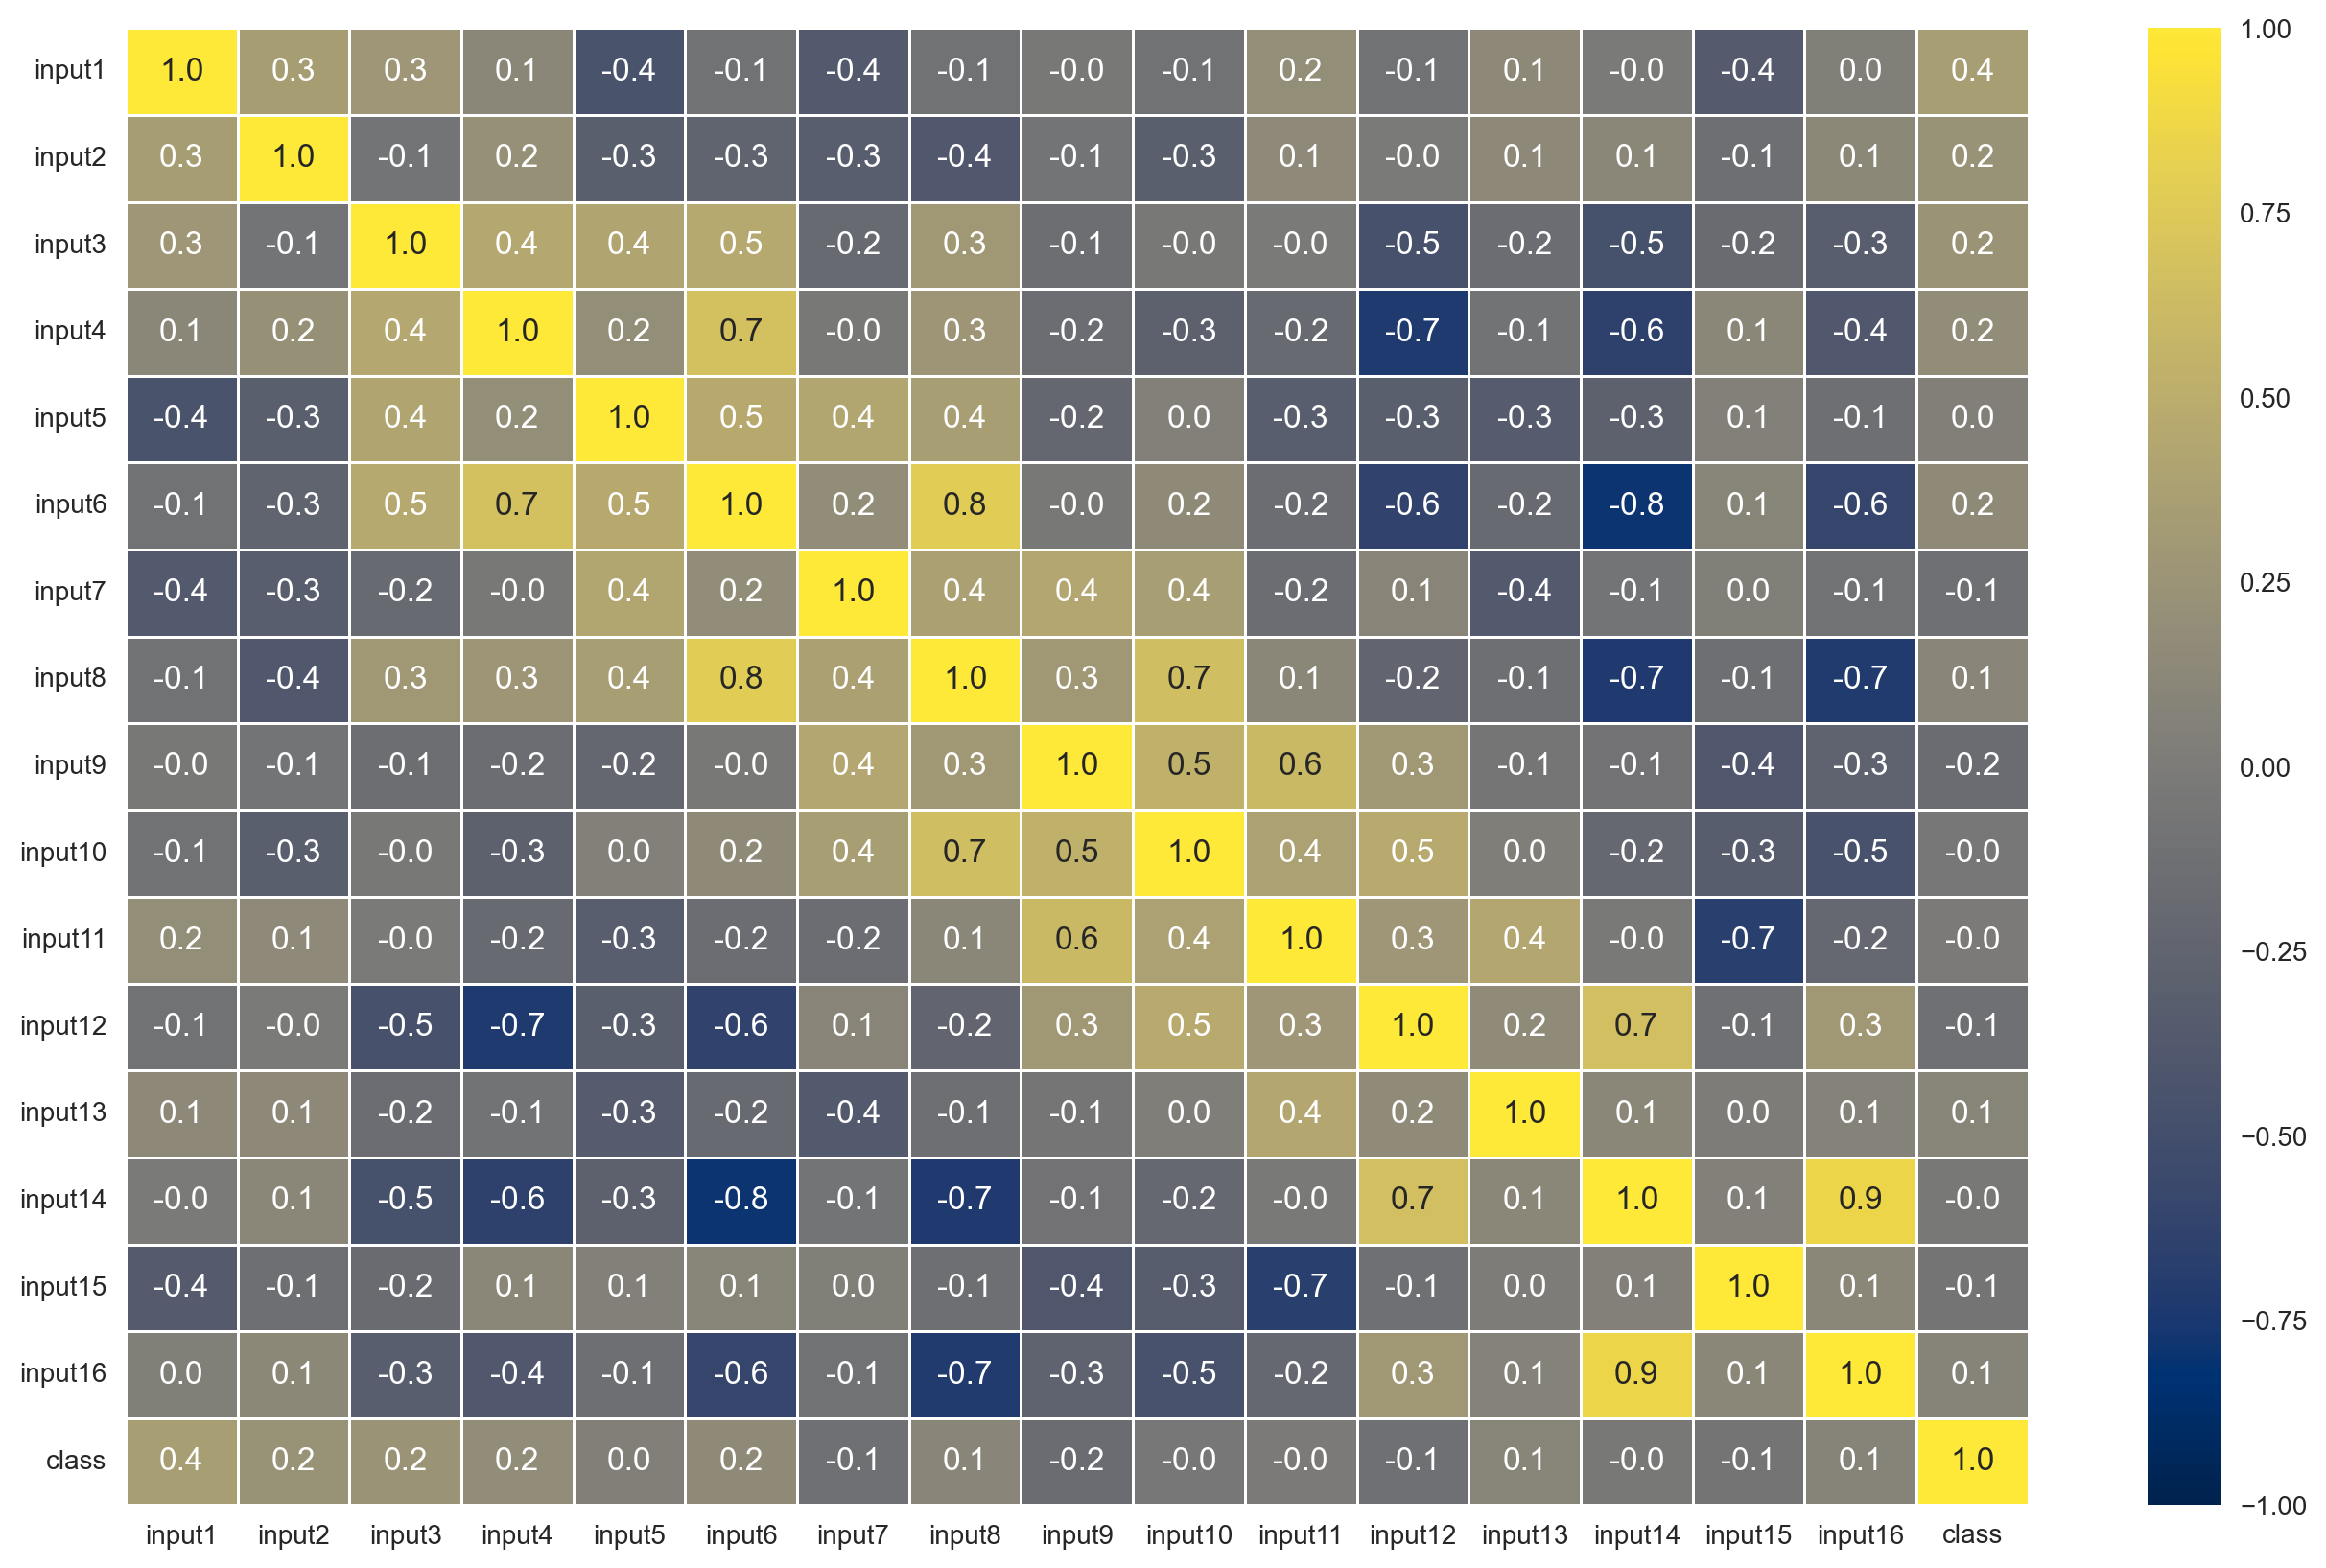

In [83]:
corr_matrix = df.corr()
plt.figure(figsize=(16, 10), dpi=200)
sns.heatmap(corr_matrix, annot=True, fmt=".1f",linewidth=.5, cmap="cividis", vmin=-1, vmax=1, annot_kws={"size": 12})

plt.show()

In [84]:
# ML Prep
X = df.drop("class", axis = 1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# we have 44 writer and by selection 25% test size; 33 writer is for train set and 11 writer for test 

In [85]:
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


# Random Forest Classifier

In [117]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
y_pred_test = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)

In [119]:
rfc_accuracy_test = accuracy_score(y_test, y_pred_test)
rfc_accuracy_train = accuracy_score(y_train, y_pred_train)

rfc_f1_test = f1_score(y_test, y_pred_test, average='macro')
rfc_f1_train = f1_score(y_train, y_pred_train, average='macro')

rfc_accuracy_test, rfc_accuracy_train, rfc_f1_test, rfc_f1_train

(0.984993178717599, 1.0, 0.9850760622746183, 1.0)

In [120]:
print("TEST REPORT")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits = 3))


print("\n"*3, "-*"*30)
print("TRAIN REPORT")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, digits = 3))

TEST REPORT
[[218   0   0   0   0   0   0   0   3   0]
 [  0 218  10   0   0   0   0   1   0   0]
 [  0   2 222   0   0   0   0   1   0   0]
 [  0   0   0 218   0   0   0   0   0   1]
 [  0   0   0   0 242   0   0   0   0   0]
 [  0   0   0   3   0 203   0   0   0   4]
 [  0   0   0   0   0   0 210   0   0   0]
 [  0   3   1   0   0   0   0 218   0   0]
 [  0   0   0   0   0   0   0   0 199   0]
 [  0   0   0   0   0   0   0   3   1 218]]
              precision    recall  f1-score   support

           0      1.000     0.986     0.993       221
           1      0.978     0.952     0.965       229
           2      0.953     0.987     0.969       225
           3      0.986     0.995     0.991       219
           4      1.000     1.000     1.000       242
           5      1.000     0.967     0.983       210
           6      1.000     1.000     1.000       210
           7      0.978     0.982     0.980       222
           8      0.980     1.000     0.990       199
           9    

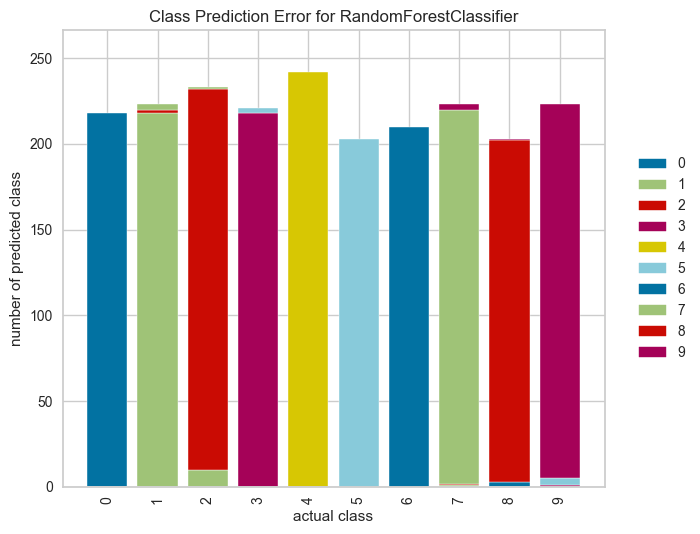

In [122]:
visualizer = ClassPredictionError(rfc)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

### RF GridsearchCV

In [134]:
param_grid = {
             'criterion': ["entropy","gini"],
             'max_depth':[7,8],
             'max_features':['auto', 0.75],
             'max_leaf_nodes': [180,200],
             'n_estimators':[50,100],
             }


In [136]:
rf_model = RandomForestClassifier()
rf_grid_model = GridSearchCV(rf_model,
                             param_grid,
                             verbose=2,
                             scoring="accuracy",
                             n_jobs=-1)

rf_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [7, 8],
                         'max_features': ['auto', 0.75],
                         'max_leaf_nodes': [180, 200],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [137]:
rf_grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.75,
 'max_leaf_nodes': 200,
 'n_estimators': 100}

In [138]:
y_pred_test = rf_grid_model.predict(X_test)
y_pred_train = rf_grid_model.predict(X_train)

In [139]:
rfc_accuracy_test = accuracy_score(y_test, y_pred_test)
rfc_accuracy_train = accuracy_score(y_train, y_pred_train)

rfc_f1_test = f1_score(y_test, y_pred_test, average='macro')
rfc_f1_train = f1_score(y_train, y_pred_train, average='macro')

rfc_accuracy_test, rfc_accuracy_train, rfc_f1_test, rfc_f1_train

(0.9768076398362893,
 0.9929489366541567,
 0.9770113648490296,
 0.9929634995756988)

In [140]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))
print("-*"*30)
print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))
print("-*"*30)
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))

TEST CM
 [[218   0   0   0   0   0   0   0   3   0]
 [  0 213  15   0   0   0   0   1   0   0]
 [  0   3 219   0   0   0   0   3   0   0]
 [  0   1   0 217   0   1   0   0   0   0]
 [  0   0   0   0 240   0   0   0   0   2]
 [  0   0   0   3   0 203   0   0   1   3]
 [  0   0   0   0   0   0 210   0   0   0]
 [  0   5   1   1   0   0   0 214   1   0]
 [  1   0   0   0   0   0   0   0 198   0]
 [  0   1   0   2   0   0   0   2   1 216]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[922   0   0   0   0   0   0   0   0   0]
 [  0 882  15  17   0   0   0   0   0   0]
 [  0   1 916   1   0   0   0   1   0   0]
 [  0   4   2 825   0   2   0   2   0   1]
 [  0   0   0   0 900   0   0   0   0   2]
 [  0   0   0   2   0 842   0   0   0   1]
 [  0   0   0   0   0   1 845   0   0   0]
 [  0   2   1   3   0   0   0 914   0   0]
 [  0   0   0   0   0   0   0   0 856   0]
 [  0   1   0   2   1   0   0   0   0 829]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

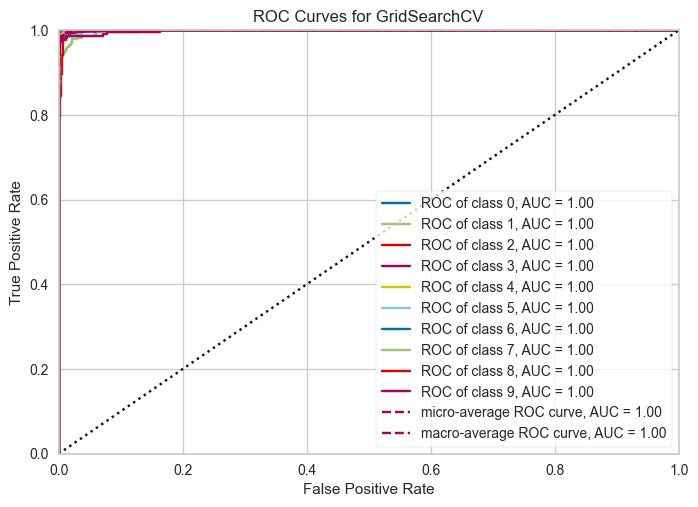

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [141]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf_grid_model, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

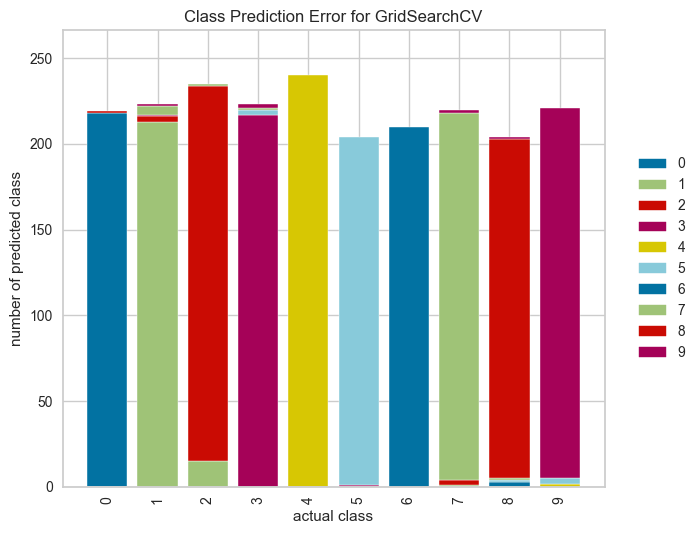

In [143]:
visualizer = ClassPredictionError(rf_grid_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

# Support Vector Machine (SVM) Classifier

In [86]:
scaler = MinMaxScaler() 

In [88]:
modelSVM =  SVC(kernel="rbf")  # default sbf

In [89]:
from sklearn.pipeline  import Pipeline

modelSVM = Pipeline([("scaler",scaler),("SVM",modelSVM)])

In [90]:
modelSVM.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVM', SVC())])

In [91]:
y_pred_test = modelSVM.predict(X_test)
y_pred_train = modelSVM.predict(X_train)

In [93]:
#skor check --> accurancy and f1
SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

# macro because of balanced data

print ('Accuracy')
print ('SVM_accuracy_test:',SVM_accuracy_test)
print ('SVM_accuracy_train:',SVM_accuracy_train)
print('--------')
print ('f1')
print ('SVM_f1_test:',svm_f1_test)
print ('SVM_f1_train:',svm_f1_train)

Accuracy
SVM_accuracy_test: 0.990450204638472
SVM_accuracy_train: 0.995678380529967
--------
f1
SVM_f1_test: 0.9904537211561903
SVM_f1_train: 0.9956930837146494


In [95]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))




TEST CM
 [[219   0   0   0   0   0   0   0   2   0]
 [  0 224   4   0   0   0   0   1   0   0]
 [  0   1 224   0   0   0   0   0   0   0]
 [  0   0   0 218   0   0   0   0   0   1]
 [  0   0   0   0 240   2   0   0   0   0]
 [  0   0   0   3   0 205   0   0   0   2]
 [  0   0   0   0   0   0 210   0   0   0]
 [  0   1   0   0   0   0   0 221   0   0]
 [  0   0   0   0   0   0   0   0 199   0]
 [  0   0   0   0   0   0   0   3   1 218]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[920   1   0   0   0   0   1   0   0   0]
 [  0 901   6   5   1   0   0   1   0   0]
 [  0   3 915   0   0   0   0   1   0   0]
 [  0   1   2 830   0   1   0   1   0   1]
 [  0   0   0   0 899   2   0   1   0   0]
 [  0   0   0   2   0 840   0   0   1   2]
 [  0   0   0   0   0   1 845   0   0   0]
 [  0   1   0   0   0   0   0 919   0   0]
 [  0   0   0   0   0   1   0   1 854   0]
 [  0   0   0   0   0   0   0   1   0 832]]


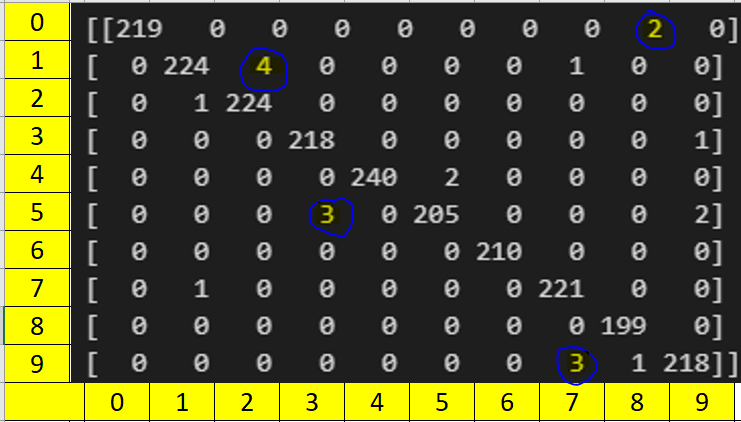

mistakes are not much
scores are close--> not over-fitting

In [97]:
#Test Report
print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))


TEST REPORT 
               precision    recall  f1-score   support

           0      1.000     0.991     0.995       221
           1      0.991     0.978     0.985       229
           2      0.982     0.996     0.989       225
           3      0.986     0.995     0.991       219
           4      1.000     0.992     0.996       242
           5      0.990     0.976     0.983       210
           6      1.000     1.000     1.000       210
           7      0.982     0.995     0.989       222
           8      0.985     1.000     0.993       199
           9      0.986     0.982     0.984       222

    accuracy                          0.990      2199
   macro avg      0.990     0.991     0.990      2199
weighted avg      0.990     0.990     0.990      2199



In [98]:
#Train Report
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))


TRAIN REPORT 
               precision    recall  f1-score   support

           0      1.000     0.998     0.999       922
           1      0.993     0.986     0.990       914
           2      0.991     0.996     0.993       919
           3      0.992     0.993     0.992       836
           4      0.999     0.997     0.998       902
           5      0.994     0.994     0.994       845
           6      0.999     0.999     0.999       846
           7      0.994     0.999     0.996       920
           8      0.999     0.998     0.998       856
           9      0.996     0.999     0.998       833

    accuracy                          0.996      8793
   macro avg      0.996     0.996     0.996      8793
weighted avg      0.996     0.996     0.996      8793



#### SVC GridsearchCV

In [99]:
param_grid = {'SVM__C':np.linspace(1, 1.3, 10),
              'SVM__gamma':["scale", "auto"]
             }

In [100]:
model = Pipeline([("scaler",scaler),("SVM", SVC(kernel="rbf"))]) 

svm_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=2,
                              scoring="accuracy",
                              n_jobs=-1) # pc just focus to this job

svm_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ]),
                         'SVM__gamma': ['scale', 'auto']},
             scoring='accuracy', verbose=2)

In [101]:
svm_model_grid.best_params_ 
# get best param

{'SVM__C': 1.3, 'SVM__gamma': 'scale'}

In [102]:
svm_model_grid.best_estimator_
# with best param

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVM', SVC(C=1.3))])

In [106]:
param_grid = {'SVM__C':np.linspace(1.3, 1.7, 10),
              'SVM__gamma':["scale", "auto"]
             }

In [107]:
model = Pipeline([("scaler",scaler),("SVM", SVC(kernel="rbf"))]) 

svm_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=2,
                              scoring="accuracy",
                              n_jobs=-1)

svm_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.3       , 1.34444444, 1.38888889, 1.43333333, 1.47777778,
       1.52222222, 1.56666667, 1.61111111, 1.65555556, 1.7       ]),
                         'SVM__gamma': ['scale', 'auto']},
             scoring='accuracy', verbose=2)

In [108]:
svm_model_grid.best_params_

{'SVM__C': 1.5666666666666667, 'SVM__gamma': 'scale'}

In [109]:
svm_model_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVM', SVC(C=1.5666666666666667))])

In [110]:
y_pred_test = svm_model_grid.predict(X_test)
y_pred_train = svm_model_grid.predict(X_train)

In [111]:
SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

SVM_accuracy_test, SVM_accuracy_train, svm_f1_test, svm_f1_train

(0.9931787175989086, 0.9965881951552371, 0.993167298589959, 0.9965924365837319)

In [112]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))

print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))
print("-*"*30)
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))

TEST CM
 [[220   0   0   0   0   0   0   0   1   0]
 [  0 226   2   0   0   0   0   1   0   0]
 [  0   1 224   0   0   0   0   0   0   0]
 [  0   0   0 218   0   0   0   0   0   1]
 [  0   0   0   0 242   0   0   0   0   0]
 [  0   0   0   3   0 206   0   0   0   1]
 [  0   0   0   0   0   0 210   0   0   0]
 [  0   1   0   0   0   0   0 221   0   0]
 [  0   0   0   0   0   0   0   0 199   0]
 [  0   0   0   0   0   0   0   3   1 218]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[920   1   0   0   0   0   1   0   0   0]
 [  0 902   6   4   1   0   0   1   0   0]
 [  0   1 917   0   0   0   0   1   0   0]
 [  0   1   2 830   0   1   0   1   0   1]
 [  0   0   0   0 902   0   0   0   0   0]
 [  0   0   0   2   0 841   0   0   1   1]
 [  0   0   0   0   0   1 845   0   0   0]
 [  0   0   0   0   0   0   0 920   0   0]
 [  0   0   0   0   0   1   0   1 854   0]
 [  0   0   0   0   0   0   0   1   0 832]]
TEST REPORT 
               precision    recall  f1-score

 better scores and predictions

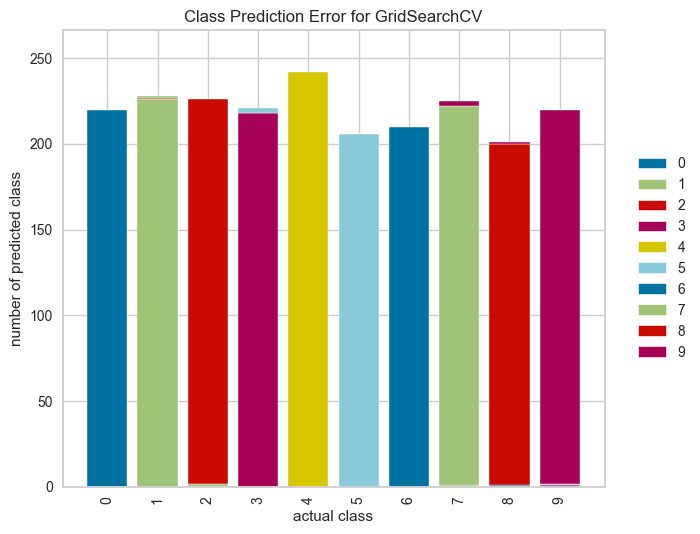

In [114]:
visualizer = ClassPredictionError(svm_model_grid)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

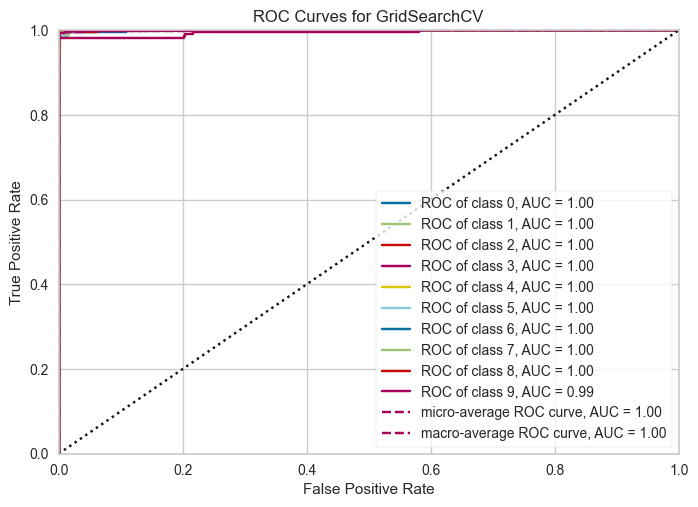

In [115]:
# ROC because data is balanced / if unbalance Prediction record
visualizer = ROCAUC(svm_model_grid, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                      # Finalize and render the figure

# Compare

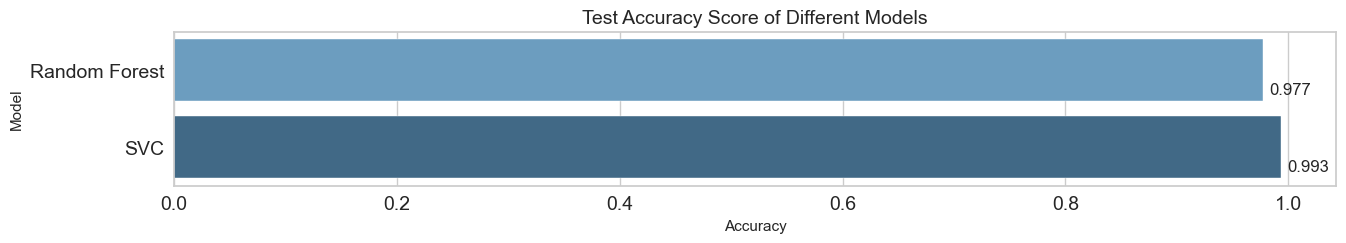

In [146]:
#Accurancy
compare = pd.DataFrame({"Model": ["SVC", "Random Forest"],
                        "Accuracy": [SVM_accuracy_test, rfc_accuracy_test]})

compare = compare.sort_values(by="Accuracy", ascending=True)

plt.figure(figsize=(15,2))
ax = sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                xytext=(5, 10), textcoords='offset points')

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Test Accuracy Score of Different Models", size=14);

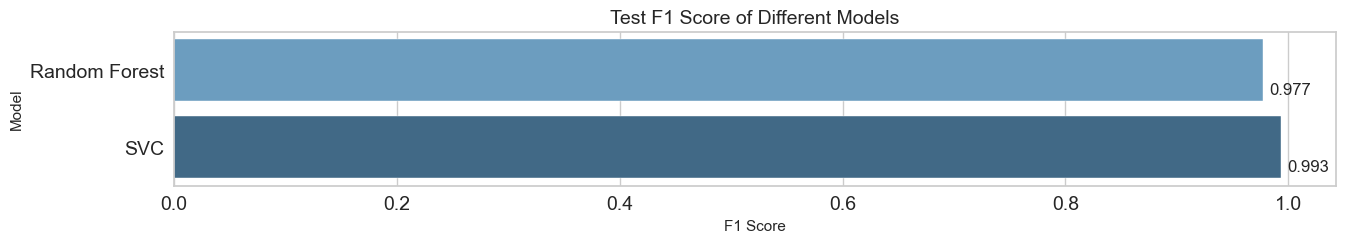

In [145]:
#f1 score
compare = pd.DataFrame({"Model": ["SVC", "Random Forest"],
                        "F1 Score": [svm_f1_test, rfc_f1_test]})

compare = compare.sort_values(by="F1 Score", ascending=True)

plt.figure(figsize=(15,2))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + .9),
                xytext=(5, 10), textcoords='offset points')

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Test F1 Score of Different Models", size=14);

# Conclusion

* RF AUC is better
* SVC Accurancy and F1 score is better
* both model have good results

Because of the dataset this two approach is good enugh to sufficent prediction
